# Proyek Klasifikasi Gambar: Vegetable Image Dataset
- **Nama:** Vania Rachmawati Dewi
- **Email:** vaniardewi@gmail.com
- **ID Dicoding:** vaniard

## Import Semua Packages/Library yang Digunakan

In [1]:
import os
import shutil
import zipfile
import random
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from random import sample
import matplotlib.pyplot as plt

import cv2
import skimage
from PIL import Image
from skimage import io, transform, img_as_ubyte, exposure, util

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.models import load_model, Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, Dense, MaxPool2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, InputLayer, SeparableConv2D

from tqdm.notebook import tqdm as tq

from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
print(tf.__version__)

2.18.0


## Data Preparation

### Data Loading

In [3]:
dataset_dir = 'dataset'

if os.path.exists(dataset_dir):
    shutil.rmtree(dataset_dir)

os.mkdir(dataset_dir)

In [5]:
target_file = 'Vegetables.zip'
extracting = zipfile.ZipFile(target_file, 'r')
extracting.extractall(dataset_dir)
extracting.close()

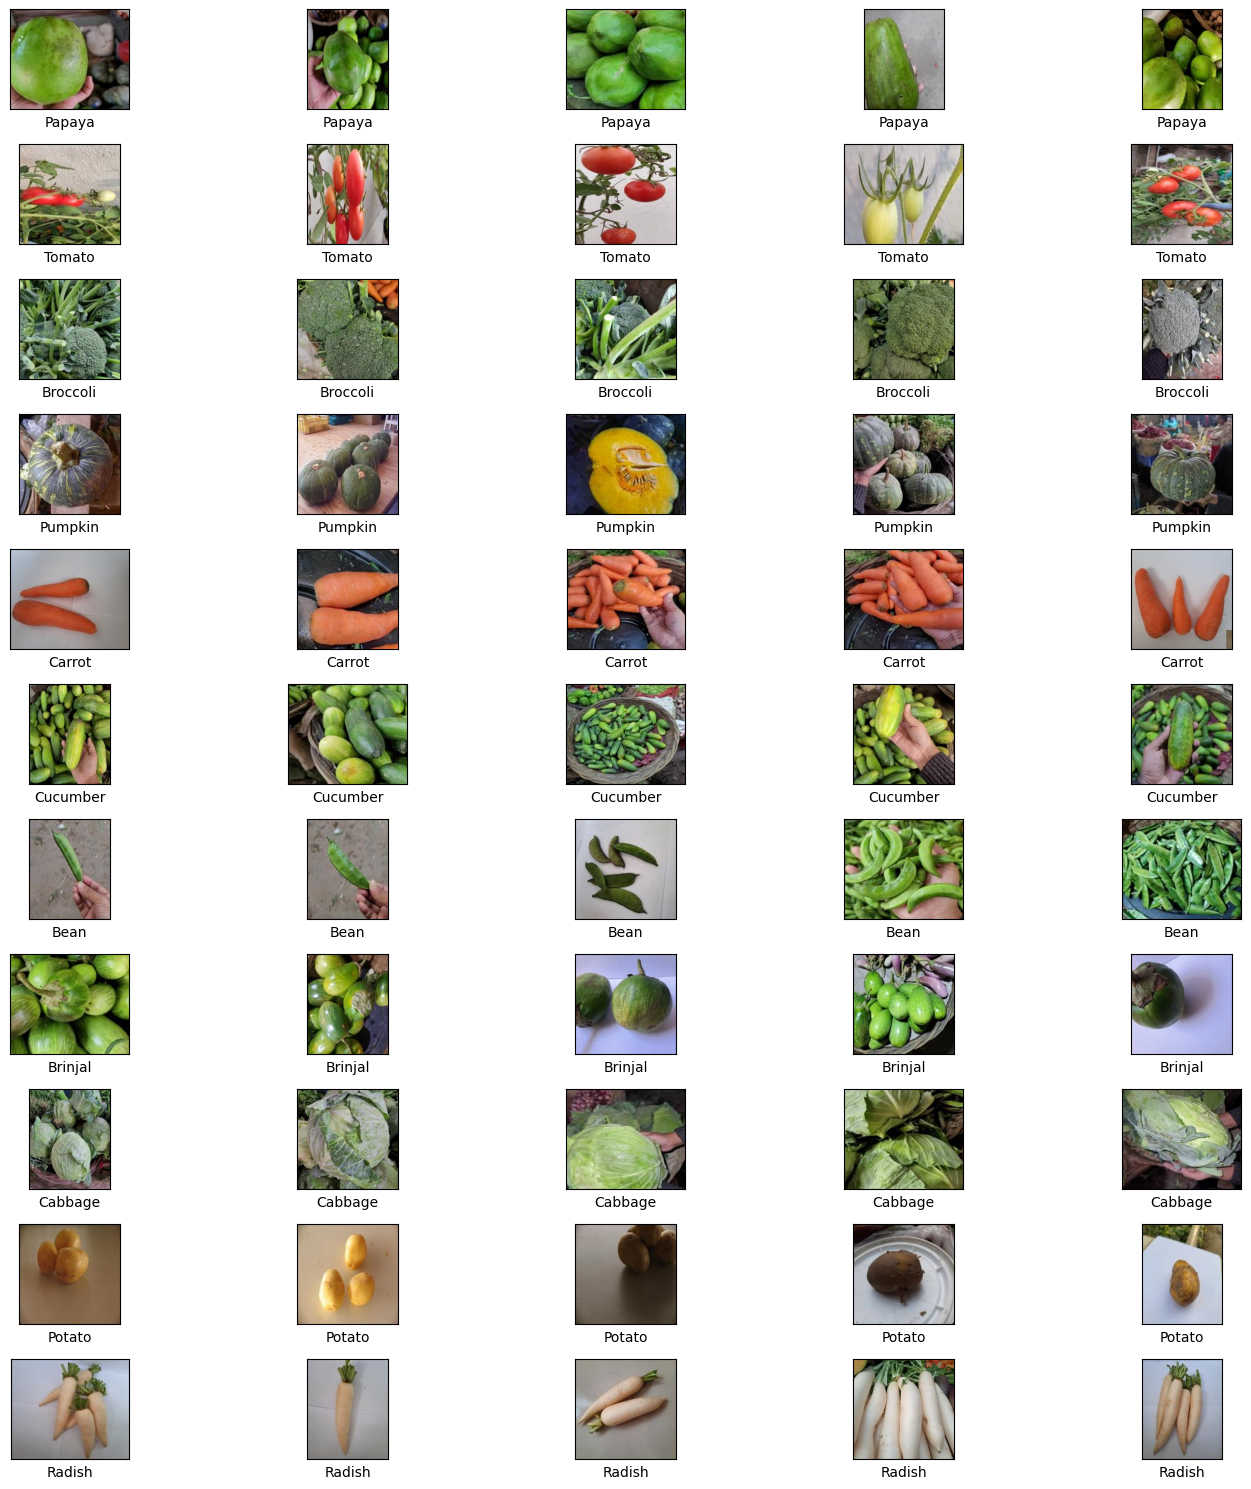

In [6]:
label_image = {}

path = '/content/dataset'

for class_name in os.listdir(path):
    class_path = os.path.join(path, class_name)
    if os.path.isdir(class_path):
        label_image[class_name] = os.listdir(class_path)

fig, axs = plt.subplots(len(label_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(label_image.keys()):
    images = np.random.choice(label_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path, class_name, image_name)
        img = Image.open(img_path)
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])

fig.tight_layout()
plt.show()

In [7]:
def print_images_resolution(directory):
    unique_sizes = set()
    total_images = 0

    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        image_files = os.listdir(subdir_path)
        num_images = len(image_files)
        print(f"{subdir}: {num_images}")
        total_images += num_images

        for img_file in image_files:
            img_path = os.path.join(subdir_path, img_file)
            with Image.open(img_path) as img:
                unique_sizes.add(img.size)

        for size in unique_sizes:
            print(f"- {size}")
        print("---------------")

    print(f"\nTotal: {total_images}")

print_images_resolution(path)

Papaya: 1000
- (160, 200)
- (160, 160)
- (224, 224)
- (200, 170)
- (190, 160)
---------------
Tomato: 1000
- (160, 200)
- (160, 160)
- (224, 224)
- (200, 170)
- (190, 160)
---------------
Broccoli: 1000
- (160, 200)
- (160, 160)
- (224, 224)
- (200, 170)
- (190, 160)
---------------
Pumpkin: 1000
- (160, 200)
- (160, 160)
- (224, 224)
- (200, 170)
- (190, 160)
---------------
Carrot: 1000
- (160, 200)
- (160, 160)
- (224, 224)
- (200, 170)
- (190, 160)
---------------
Cucumber: 1000
- (160, 200)
- (160, 160)
- (224, 224)
- (200, 170)
- (190, 160)
---------------
Bean: 1000
- (160, 200)
- (160, 160)
- (224, 224)
- (200, 170)
- (190, 160)
---------------
Brinjal: 1000
- (160, 200)
- (160, 160)
- (224, 224)
- (200, 170)
- (190, 160)
---------------
Cabbage: 1000
- (160, 200)
- (160, 160)
- (224, 224)
- (200, 170)
- (190, 160)
---------------
Potato: 1000
- (160, 200)
- (160, 160)
- (224, 224)
- (200, 170)
- (190, 160)
---------------
Radish: 1000
- (160, 200)
- (160, 160)
- (224, 224)
- (

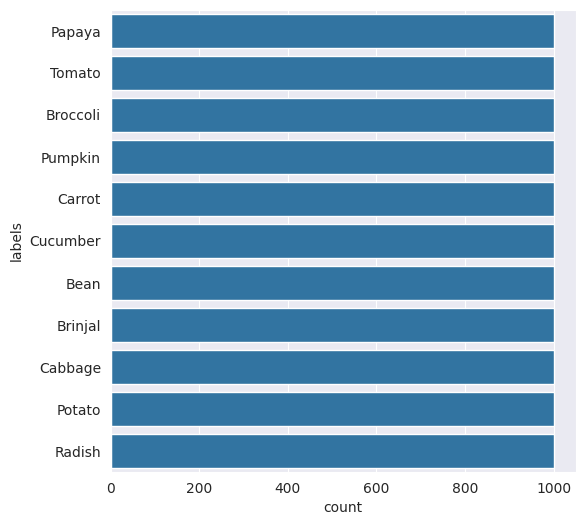

In [8]:
label_path = "/content/dataset"

file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(label_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(os.path.basename(path))
        file_name.append(name)

dist_train = pd.DataFrame({"path": full_path, 'file_name': file_name, "labels": labels})

Label = dist_train['labels']
plt.figure(figsize=(6, 6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

plt.show()

In [9]:
total_data = dist_train.shape[0]
print(f"Total data: {total_data}")

Total data: 11000


### Data Preprocessing

#### Split Dataset

In [10]:
class_list = ['Bean', 'Brinjal', 'Broccoli', 'Cabbage','Carrot', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']

In [11]:
train_percentage = 0.8

train_dataset_dir = 'training'
test_dataset_dir = 'testing'

os.makedirs(train_dataset_dir, exist_ok=True)
os.makedirs(test_dataset_dir, exist_ok=True)

In [12]:
for dirname in class_list:
    classpath = os.path.join(dataset_dir, dirname)

    counter = 0
    train_length = train_percentage * len(os.listdir(classpath))

    train_classpath = os.path.join(train_dataset_dir, dirname)
    test_classpath = os.path.join(test_dataset_dir, dirname)

    os.mkdir(train_classpath)
    os.mkdir(test_classpath)

    for filename in os.listdir(classpath):
        filepath = os.path.join(classpath, filename)

        if counter < train_length:
            shutil.move(filepath, train_classpath)
        else:
            shutil.move(filepath, test_classpath)

        counter += 1

In [13]:
train_path = "/content/training"

train_file_name = []
train_labels = []
train_full_path = []

for path, subdirs, files in os.walk(train_path):
    for name in files:
        train_full_path.append(os.path.join(path, name))
        train_labels.append(os.path.basename(path))
        train_file_name.append(name)

dist_train = pd.DataFrame({"path": train_full_path, 'file_name': train_file_name, "labels": train_labels})

In [14]:
test_path = "/content/testing"

test_file_name = []
test_labels = []
test_full_path = []

for path, subdirs, files in os.walk(test_path):
    for name in files:
        test_full_path.append(os.path.join(path, name))
        test_labels.append(os.path.basename(path))
        test_file_name.append(name)

distribution_test = pd.DataFrame({"path": test_full_path, 'file_name': test_file_name, "labels": test_labels})

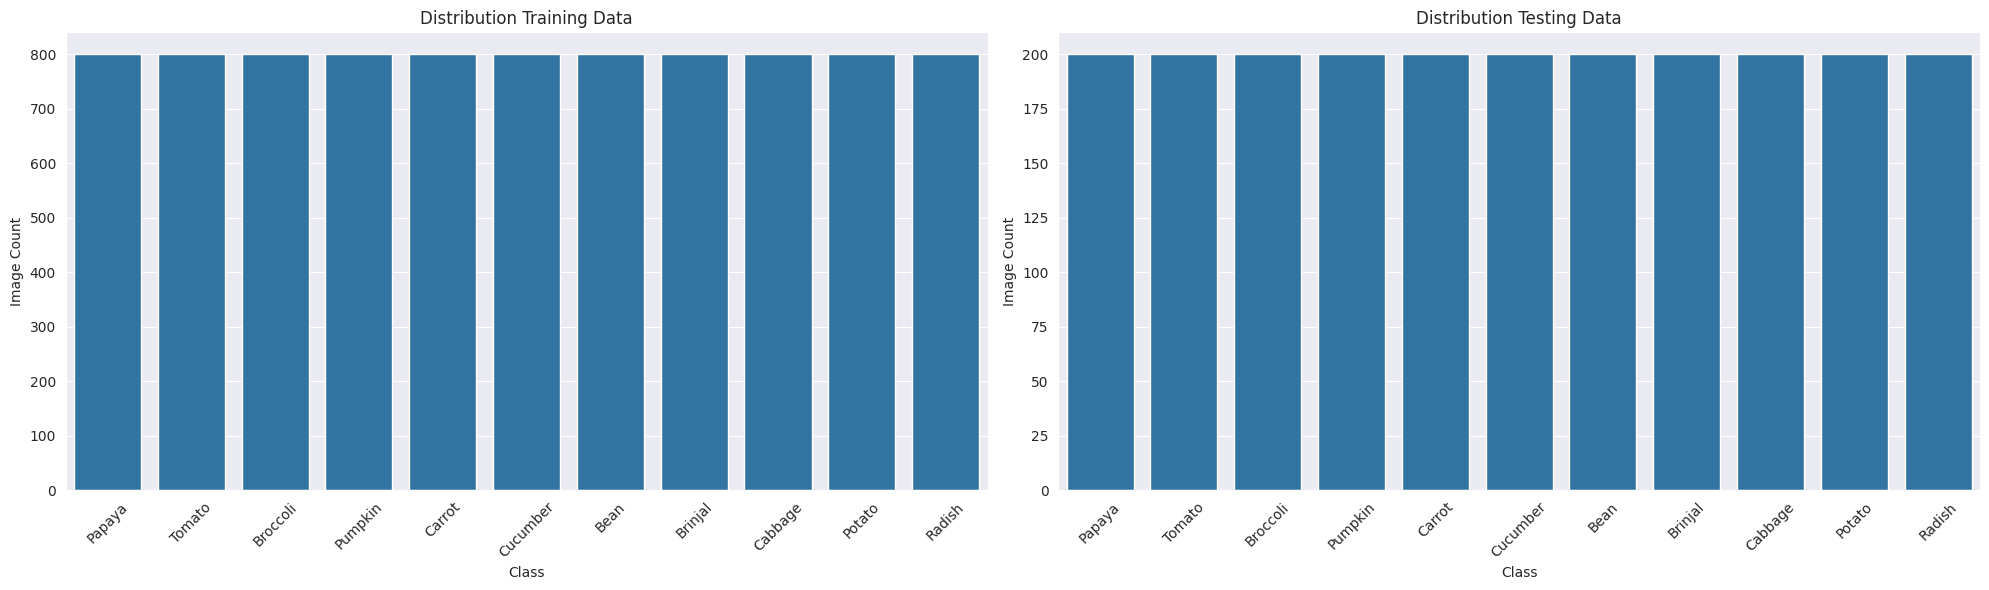

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

sns.set_style("darkgrid")

sns.countplot(x='labels', data=dist_train, ax=axes[0])
axes[0].set_title('Distribution Training Data')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Image Count')
axes[0].tick_params(axis='x', rotation=45)

sns.countplot(x='labels', data=distribution_test, ax=axes[1])
axes[1].set_title('Distribution Testing Data')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Image Count')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [16]:
data_genenator = ImageDataGenerator(rescale=1./255,
                            validation_split = 0.2,
                            rotation_range=40,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            shear_range=0.2,
                            zoom_range=0.2,
                            horizontal_flip=True,
                            fill_mode='nearest',)

test_datagenenerator = ImageDataGenerator(rescale=1. / 255)

train_gen = data_genenator.flow_from_directory(train_path,
                                              batch_size=32,
                                              target_size=(150,150),
                                              class_mode='categorical',
                                              subset='training',
                                              shuffle=True)

validation_gen = data_genenator.flow_from_directory(train_path,
                                                   batch_size=32,
                                                   target_size=(150,150),
                                                   class_mode='categorical',
                                                   subset='validation',
                                                   shuffle=False)

test_gen = test_datagenenerator.flow_from_directory(test_path,
                                                  batch_size=32,
                                                  target_size=(150,150),
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 7040 images belonging to 11 classes.
Found 1760 images belonging to 11 classes.
Found 2200 images belonging to 11 classes.


## Modelling

In [17]:
model = Sequential([
    tf.keras.Input(shape=(150, 150, 3)),
    Conv2D(32, (5, 5), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (5, 5), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(11, activation='softmax')
])

In [18]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') > 0.97 and logs.get('val_accuracy') > 0.97:
            print("\nAkurasi pelatihan dan validasi telah mencapai >97%! Pelatihan dihentikan.")
            self.model.stop_training = True
callbacks = myCallback()

class EarlyStoppingAlert(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if self.model.stop_training:
            print(f"\nEarly stopping triggered at epoch {epoch + 1}")

In [19]:
early_stop = EarlyStopping(monitor='val_loss', patience=10 )

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

early_stop_alert = EarlyStoppingAlert()

callback_list = [early_stop, reduce_lr, early_stop_alert, callbacks]

In [20]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=1e-4),
              metrics=['accuracy'])

In [21]:
history = model.fit(
        train_gen,
        epochs = 100,
        validation_data = validation_gen,
        verbose = 2,
        callbacks = callback_list,
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
220/220 - 78s - 354ms/step - accuracy: 0.3463 - loss: 1.8082 - val_accuracy: 0.5420 - val_loss: 1.3287 - learning_rate: 1.0000e-04
Epoch 2/100
220/220 - 73s - 331ms/step - accuracy: 0.5753 - loss: 1.2228 - val_accuracy: 0.6739 - val_loss: 0.9526 - learning_rate: 1.0000e-04
Epoch 3/100
220/220 - 59s - 267ms/step - accuracy: 0.6710 - loss: 0.9481 - val_accuracy: 0.7176 - val_loss: 0.8068 - learning_rate: 1.0000e-04
Epoch 4/100
220/220 - 54s - 243ms/step - accuracy: 0.7314 - loss: 0.7874 - val_accuracy: 0.7648 - val_loss: 0.7127 - learning_rate: 1.0000e-04
Epoch 5/100
220/220 - 52s - 235ms/step - accuracy: 0.7689 - loss: 0.7011 - val_accuracy: 0.8330 - val_loss: 0.5226 - learning_rate: 1.0000e-04
Epoch 6/100
220/220 - 54s - 246ms/step - accuracy: 0.7960 - loss: 0.6189 - val_accuracy: 0.8034 - val_loss: 0.5447 - learning_rate: 1.0000e-04
Epoch 7/100
220/220 - 53s - 239ms/step - accuracy: 0.8173 - loss: 0.5711 - val_accuracy: 0.8460 - val_loss: 0.4546 - learning_rate: 1.0000e-04

## Evaluasi dan Visualisasi

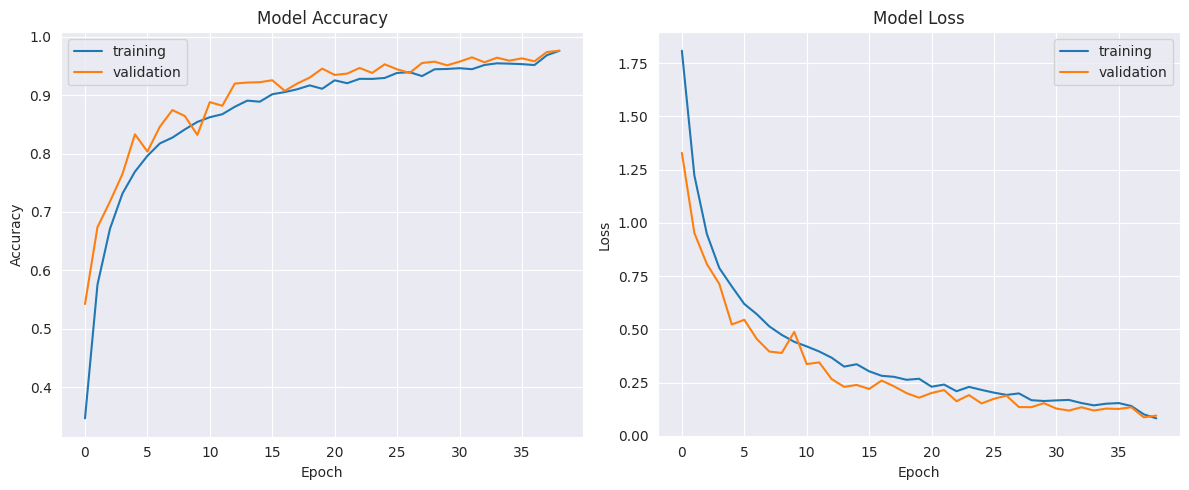

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot Accuracy
ax1.plot(history.history['accuracy'], label='training')
ax1.plot(history.history['val_accuracy'], label='validation')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot Loss
ax2.plot(history.history['loss'], label='training')
ax2.plot(history.history['val_loss'], label='validation')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

In [23]:
train = model.evaluate(train_gen)
valid = model.evaluate(validation_gen)

print()
print(f'Training Accuracy : {train[1]*100:0.2f}')
print(f'Validation Accuracy : {valid[1]*100:0.2f}')

220/220 ━━━━━━━━━━━━━━━━━━━━ 40s 184ms/step - accuracy: 0.9840 - loss: 0.0564
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 187ms/step - accuracy: 0.9730 - loss: 0.0783

Training Accuracy : 98.42
Validation Accuracy : 97.33




              precision    recall  f1-score   support

        Bean     0.9581    1.0000    0.9786       160
     Brinjal     0.9560    0.9500    0.9530       160
    Broccoli     0.9518    0.9875    0.9693       160
     Cabbage     0.9871    0.9563    0.9714       160
      Carrot     1.0000    1.0000    1.0000       160
    Cucumber     0.9873    0.9688    0.9779       160
      Papaya     0.9686    0.9625    0.9655       160
      Potato     1.0000    1.0000    1.0000       160
     Pumpkin     0.9873    0.9750    0.9811       160
      Radish     1.0000    1.0000    1.0000       160
      Tomato     0.9874    0.9812    0.9843       160

    accuracy                         0.9801      1760
   macro avg     0.9803    0.9801    0.9801      1760
weighted avg     0.9803    0.9801    0.9801      1760



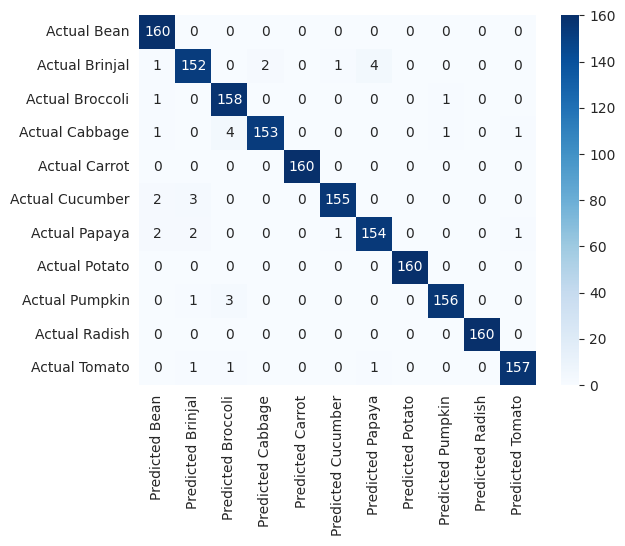

In [24]:
validation_gen.reset()

pred_valid = model.predict(validation_gen, verbose=0, batch_size=128)

pred_valid_classes = pred_valid.argmax(axis=-1)

cm = pd.DataFrame(data=confusion_matrix(validation_gen.classes, pred_valid_classes, labels=list(range(len(class_list)))),
                  index=[f"Actual {label}" for label in class_list],
                  columns=[f"Predicted {label}" for label in class_list])
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')

print("\n")
print(classification_report(y_true=validation_gen.classes, y_pred=pred_valid_classes, target_names=class_list, digits=4))

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()




              precision    recall  f1-score   support

        Bean     0.9756    1.0000    0.9877       200
     Brinjal     0.9336    0.9850    0.9586       200
    Broccoli     0.9163    0.9850    0.9494       200
     Cabbage     0.9742    0.9450    0.9594       200
      Carrot     1.0000    1.0000    1.0000       200
    Cucumber     0.9896    0.9500    0.9694       200
      Papaya     0.9949    0.9750    0.9848       200
      Potato     1.0000    1.0000    1.0000       200
     Pumpkin     0.9848    0.9750    0.9799       200
      Radish     0.9950    0.9950    0.9950       200
      Tomato     0.9947    0.9400    0.9666       200

    accuracy                         0.9773      2200
   macro avg     0.9781    0.9773    0.9773      2200
weighted avg     0.9781    0.9773    0.9773      2200



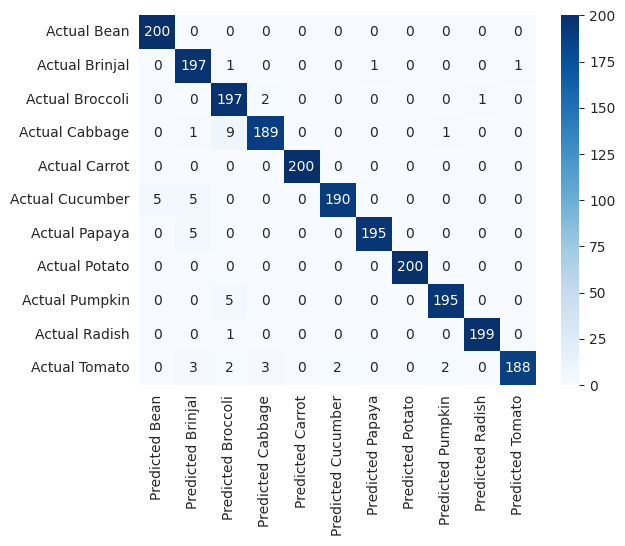

In [25]:
test_gen.reset()

pred_test = model.predict(test_gen, verbose=0, batch_size=32)

pred_test_classes = pred_test.argmax(axis=-1)

cm = pd.DataFrame(data=confusion_matrix(test_gen.classes, pred_test_classes, labels=list(range(len(class_list)))),
                  index=[f"Actual {label}" for label in class_list],
                  columns=[f"Predicted {label}" for label in class_list])
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')

print("\n")
print(classification_report(y_true=test_gen.classes, y_pred=pred_test_classes, target_names=class_list, digits=4))

## Konversi Model

In [26]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.3 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
google-cloud-bigquery 3.32.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [27]:
import tensorflow as tf
import os

saved_model_dir = "/content/saved_model"

os.makedirs(saved_model_dir, exist_ok=True)

model.export(saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

os.makedirs('tflite', exist_ok=True)

label_kelas = {
    0: 'Bean',
    1: 'Brinjal',
    2: 'Broccoli',
    3: 'Cabbage',
    4: 'Carrot',
    5: 'Cucumber',
    6: 'Papaya',
    7: 'Potato',
    8: 'Pumpkin',
    9: 'Radish',
    10: 'Tomato'
}

with open('tflite/labels.txt', 'w') as f:
    for key, value in label_kelas.items():
        f.write(f"{key} {value}\n")

with tf.io.gfile.GFile('tflite/model.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/content/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 11), dtype=tf.float32, name=None)
Captures:
  132909639597904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132909538001744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132909538004624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132909538003472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132909538004048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132909538005392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132909538001552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132909538005776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132909538006160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132909538007696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132909538

In [28]:
!tensorflowjs_converter --input_format=tf_saved_model  /content/saved_model /content/tfjs_model

2025-05-18 09:26:28.985942: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747560389.019845   13847 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747560389.029855   13847 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-05-18 09:26:36.717269: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1747560396.717446   13847 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

## Inference (Optional)

Saving tomat.jpg to tomat.jpg


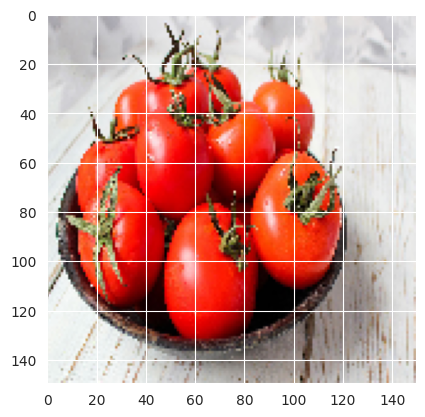

Kelas yang Diprediksi: Tomato, Tingkat Keyakinan: 100.00%


In [29]:
from google.colab import files

uploaded = files.upload()

image_path = list(uploaded.keys())[0]

img = image.load_img(image_path, target_size=(150, 150))

plt.imshow(img)
plt.show()

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0

model_path = '/content/tflite/model.tflite'

interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

interpreter.set_tensor(input_details[0]['index'], x)

interpreter.invoke()

predictions = interpreter.get_tensor(output_details[0]['index'])

predicted_class = np.argmax(predictions)
confidence = predictions[0][predicted_class] * 100

label_kelas = { 0: 'Bean', 1: 'Brinjal', 2: 'Broccoli', 3: 'Cabbage', 4: 'Carrot', 5: 'Cucumber', 6: 'Papaya', 7: 'Potato', 8: 'Pumpkin', 9: 'Radish', 10: 'Tomato'}
label_prediksi = label_kelas[predicted_class]

print(f"Kelas yang Diprediksi: {label_prediksi}, Tingkat Keyakinan: {confidence:.2f}%")

In [30]:
!pip freeze > requirements.txt

In [35]:
from google.colab import files
import os

# Periksa apakah file zip berhasil dibuat
if os.path.exists('/content/submission/submission.zip'):
    print("File submission.zip ditemukan di /content/submission/")
    # Unduh file zip
    files.download('/content/submission/submission.zip')
else:
    print("File submission.zip tidak ditemukan di /content/submission/")

File submission.zip ditemukan di /content/submission/


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>